# Modelo de predicción de éxito de las startups

En este enlace hacen un EDA y depuración de nuestro dataset, nos puede servir como guía:

https://www.kaggle.com/ajaygorkar/eda-startup-success-analysis

## 1. Importación de librerías

**Librerías generales**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import roc_auc_score

**Librerías para gráficos**

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

**Manipulación de variables categóricas**

In [3]:
pip install pycats

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pycats 
from pycats import cat_lump

**Configuración**

In [5]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

## 2. Importación de datos

In [6]:
import os
current_path = os.getcwd() #obtener la ruta donde se guarda este cuaderno
dataset_path =current_path+'/startups_data.csv' #obtener la ruta donde se guarda el conjunto de datos de startups

In [7]:
original_df=pd.read_csv(dataset_path, na_values=['none','None'])

## 3. Análisis exploratorio inicial

### 3.1. Análisis inicial de las variables

In [8]:
original_df.head()

,Company_Name,Dependent-Company Status,year of founding,Age of company in years,Internet Activity Score,Short Description of company profile,Industry of company,Focus functions of company,Investors,Employee Count,Employees count MoM change,Has the team size grown,Est. Founding Date,Last Funding Date,Last Funding Amount,Country of company,Continent of company,Number of Investors in Seed,Number of Investors in Angel and or VC,Number of Co-founders,Number of of advisors,Team size Senior leadership,Team size all employees,Presence of a top angel or venture fund in previous round of investment,Number of of repeat investors,Number of Sales Support material,Worked in top companies,Average size of companies worked for in the past,Have been part of startups in the past?,Have been part of successful startups in the past?,Was he or she partner in Big 5 consulting?,Consulting experience?,Product or service company?,Catering to product/service across verticals,Focus on private or public data?,Focus on consumer data?,Focus on structured or unstructured data,Subscription based business,Cloud or platform based serive/product?,Local or global player,Linear or Non-linear business model,"Capital intensive business e.g. e-commerce, Engineering products and operations can also cause a business to be capital intensive",Number of of Partners of company,Crowdsourcing based business,Crowdfunding based business,Machine Learning based business,Predictive Analytics business,Speech analytics business,Prescriptive analytics business,Big Data Business,Cross-Channel Analytics/ marketing channels,Owns data or not? (monetization of data) e.g. Factual,Is the company an aggregator/market place? e.g. Bluekai,Online or offline venture - physical location based business or online venture?,B2C or B2B venture?,Top forums like 'Tech crunch' or 'Venture beat' talking about the company/model - How much is it being talked about?,Average Years of experience for founder and co founder,Exposure across the globe,Breadth of experience across verticals,Highest education,Years of education,Specialization of highest education,Relevance of education to venture,Relevance of experience to venture,Degree from a Tier 1 or Tier 2 university?,Renowned in professional circle,Experience in selling and building products,Experience in Fortune 100 organizations,Experience in Fortune 500 organizations,Experience in Fortune 1000 organizations,Top management similarity,Number of Recognitions for Founders and Co-founders,Number of of Research publications,Skills score,Team Composition score,Dificulty of Obtaining Work force,Pricing Strategy,Hyper localisation,Time to market service or product,Employee benefits and salary structures,Long term relationship with other founders,Proprietary or patent position (competitive position),Barriers of entry for the competitors,Company awards,Controversial history of founder or co founder,Legal risk and intellectual property,Client Reputation,google page rank of company website,Technical proficiencies to analyse and interpret unstructured data,Solutions offered,Invested through global incubation competitions?,Industry trend in investing,Disruptiveness of technology,Number of Direct competitors,Employees per year of company existence,Last round of funding received (in milionUSD),"Survival through recession, based on existence of the company through recession times",Time to 1st investment (in months),"Avg time to investment - average across all rounds, measured from previous investment",Gartner hype cycle stage,Time to maturity of technology (in years),Percent_skill_Entrepreneurship,Percent_skill_Operations,Percent_skill_Engineering,Percent_skill_Marketing,Percent_skill_Leadership,Percent_skill_Data Science,Percent_skill_Business Strategy,Percent_skill_Product Management,Percent_skill_Sales,Percent_skill_Domain,Percent_skill_Law,Percent_skill_Consulting,Percent_skill_Finance,Percent_skill_Investment,Renown score
0,Company1,Success,No Info,No Info,-1.0,Video di

In [9]:
len(original_df)

472

In [10]:
len(original_df.columns)

116

El dataset tiene 116 columnas y 472 filas

### 3.2. Distribución de la variable target

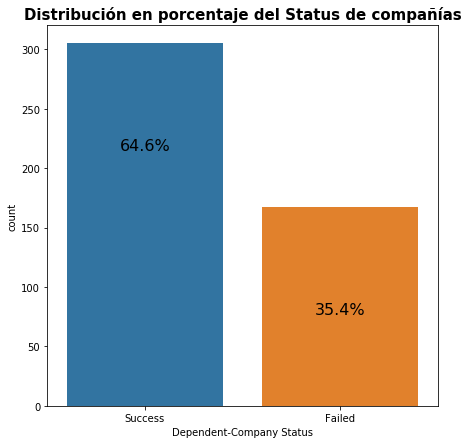

In [11]:
# Analizamos la variable dependiente -> 'Dependent-Company Status'
plt.figure(figsize=(7,7))
plt.title("Distribución en porcentaje del Status de compañías",{'fontweight':"bold",'fontsize':15})

plt.xlabel("Status de las compañías")
plt.ylabel("Cantidad de compañías")

countx = sns.countplot(original_df["Dependent-Company Status"])
sumatoria = []
for i in countx.patches:
    sumatoria.append(i.get_height())
total = sum(sumatoria)

for i in countx.patches:
    countx.text(i.get_x()+0.27, i.get_height()-90, \
            str(round((i.get_height()/total)*100,1))+'%', fontsize=16)


- El 64.6% de las empresas han tenido éxito y el 35.4% han fracasado, podríamos inferir que el dataset NO está equilibrado en referencia a la distribución de la variable target.

## 4. Procesamiento previo de los datos

### 4.1 Eliminación de variables no informativas

Eliminamos variables que no van a aportar nada al modelo:

- Short Description of company profile: descripción de la empresa, es texto libre (difícil de manejar) y su información relevante viene recogida en otras variables
- Investors: variable que contiene el nombre de los inversionistas, tenemos datos de inversionistas más relevantes en otras variables, como por ejemplo el número de inversionistas en el origen

La variable Company_Name no se elimina, ya que es la clave primaria: se necesita para identificar a las empresas. Sin embargo, hay que tener en cuenta que esta variable no debe introducirse como input del modelo.

In [12]:
df_var_elim=original_df.drop(['Short Description of company profile', 'Investors'], axis=1) 

### 4.2. Renombrado de columnas 

Renombramos las columnas a nombres más cortos y sin espacios para una manipulación más fácil

In [13]:
df_var_elim.rename(columns={'Company_Name':'company_name',
                                       'Dependent-Company Status': 'status',
                                       'year of founding': 'fundation_year',
                                       'Age of company in years': 'age_years',
                                       'Internet Activity Score': 'internet_score',
                                       'Industry of company': 'industry',
                                       'Focus functions of company': 'focus_functions',
                                       'Investors': 'investors',
                                       'Employee Count':'count_employee',
                                       'Employees count MoM change': 'count_employee_MoM_change',
                                       'Has the team size grown': 'has_team_size_grown',
                                       'Est. Founding Date':'est_founding_date',
                                       'Last Funding Date': 'last_funding_date',
                                       'Last Funding Amount':'last_funding_amount',
                                       'Country of company':'country',
                                       'Continent of company':'continent',
                                       'Number of Investors in Seed':'number_investors_seed',
                                        'Number of Investors in Angel and or VC': 'number_investors_angel_VC',
                                        'Number of Co-founders':'number_cofounders',
                                        'Number of of advisors':'number_advisors',
                                        'Team size Senior leadership':'team_size_senior_lead',
                                        'Team size all employees':'team_size_all_employees',
                                        'Presence of a top angel or venture fund in previous round of investment':'presence_angel_venture_fund',
                                        'Number of of repeat investors':'number_repeat_investors',
                                        'Number of  Sales Support material':'number_sales_support_material',
                                        'Worked in top companies':'worked_top_company',
                                        'Average size of companies worked for in the past':'avg_size_companies_worked_for_past',
                                        'Have been part of startups in the past?':'part_of_startups_past',
                                        'Have been part of successful startups in the past?':'part_of_success_startups_past',
                                        'Was he or she partner in Big 5 consulting?':'partner_big5_consulting',
                                        'Consulting experience?':'consulting_experience',
                                        'Product or service company?':'product_or_service_company',
                                        'Catering to product/service across verticals':'catering_product_service_across_verticals',
                                        'Focus on private or public data?' :'focus_private_or_public_data',
                                        'Focus on consumer data?':'focus_consumer_data',
                                        'Focus on structured or unstructured data' :'focus_structured_unstructured_data',
                                        'Subscription based business':'subscription_based',
                                        'Cloud or platform based serive/product?' :'cloud_or_platform_based',
                                        'Local or global player':'local_or_global_player',
                                        'Linear or Non-linear business model':'linear_nonlinear_business',
                                        'Capital intensive business e.g. e-commerce, Engineering products and operations can also cause a business to be capital intensive':'capital_intensive',
                                        'Number of  of Partners of company' :'number_partners',
                                        'Crowdsourcing based business':'crowdsourcing_business',
                                        'Crowdfunding based business':'crowdfunding_business',
                                        'Machine Learning based business':'ML_business',
                                        'Predictive Analytics business':'predictive_analytics_business',
                                        'Speech analytics business':'speech_analytics_business',
                                        'Prescriptive analytics business' :'prescriptive_analytics_business',
                                        'Big Data Business':'big_data_business',
                                        'Cross-Channel Analytics/ marketing channels':'cross_channel_analytics_or_marketing',
                                        'Owns data or not? (monetization of data) e.g. Factual':'owns_data',
                                        'Is the company an aggregator/market place? e.g. Bluekai':'aggregator_or_market_place',
                                        'Online or offline venture - physical location based business or online venture?':'online_or_offline_business',
                                        'B2C or B2B venture?':'B2C_or_B2B',
                                        "Top forums like 'Tech crunch' or 'Venture beat' talking about the company/model - How much is it being talked about?":'top_forums_talking_about_company',
                                        'Average Years of experience for founder and co founder':'avg_years_experience for founder and co founder',
                                        'Exposure across the globe':'exposure_across_globe',
                                        'Breadth of experience across verticals':'breadth_experience_across_verticals',
                                        'Highest education' :'highest_education',
                                        'Years of education':'years_education',
                                        'Specialization of highest education':'specialization_highest_education',
                                        'Relevance of education to venture':'relevance_education_venture',
                                        'Relevance of experience to venture':'relevance_experience_venture',
                                        'Degree from a Tier 1 or Tier 2 university?':'degree_tier1_tier2_university',
                                        'Renowned in professional circle':'renowned_professional_circle',
                                        'Experience in selling and building products':'experience_selling_building_products',
                                        'Experience in Fortune 100 organizations':'experience_fortune_100_organizations',
                                        'Experience in Fortune 500 organizations':'experience_fortune_500_organizations',
                                        'Experience in Fortune 1000 organizations' :'experience_fortune_1000_organizations',
                                        'Top management similarity':'top_management_similarity',
                                        'Number of Recognitions for Founders and Co-founders':'number_recognitions_for_founders_cofounders',
                                        'Number of  of Research publications':'number_research_publications',
                                        'Skills score':'skills_score',
                                        'Team Composition score':'team_composition_score',
                                        'Dificulty of Obtaining Work force':'difficulty_obtain_workforce',
                                        'Pricing Strategy' :'pricing_strategy',
                                        'Hyper localisation':'hyper_localisation',
                                        'Time to market service or product':'time_market_service_product',
                                        'Employee benefits and salary structures':'employee_benefits_salary_structures',
                                        'Long term relationship with other founders':'long_term_relation_other_founders',
                                        'Proprietary or patent position (competitive position)':'proprietary_patent_position',
                                        'Barriers of entry for the competitors':'barriers_entry_competitors',
                                        'Company awards':'company_awards',
                                        'Controversial history of founder or co founder':'controversial_history_founder_cofounder',
                                        'Legal risk and intellectual property' :'legal_risk_intell_property',
                                        'Client Reputation':'client_reputation',
                                        'google page rank of company website':'google_page_rank_company_web',
                                        'Technical proficiencies to analyse and interpret unstructured data':'technical_skills_analyse_unstructured_data',
                                        'Solutions offered' :'solutions_offered',
                                        'Invested through global incubation competitions?':'invested_through_global_incubation_competitions',
                                        'Industry trend in investing' :'industry_trend_investing',
                                        'Disruptiveness of technology':'disruptiveness_technology',
                                        'Number of Direct competitors' :'number_direct_competitors',
                                        'Employees per year of company existence':'employees_per_year_existence',
                                        'Last round of funding received (in milionUSD)':'last_round_fundind_millionUSD',
                                        'Survival through recession, based on existence of the company through recession times':'survival_through_recession',
                                        'Time to 1st investment (in months)':'months_to_1st_investment',
                                        'Avg time to investment - average across all rounds, measured from previous investment':'avg_time_to_investment',
                                        'Gartner hype cycle stage':'gartner_hype_cycle_stage',
                                        'Time to maturity of technology (in years)':'time_maturity_technology',
                                        'Percent_skill_Entrepreneurship' :'perc_skill_entrepreneur',
                                        'Percent_skill_Operations':'perc_skill_operations',
                                        'Percent_skill_Engineering':'perc_skill_engineering', 
                                        'Percent_skill_Marketing':'perc_skill_marketing',
                                        'Percent_skill_Leadership' :'perc_skill_leadership',
                                        'Percent_skill_Data Science':'perc_skill_datascience',
                                        'Percent_skill_Business Strategy' :'perc_skill_business_strategy',
                                        'Percent_skill_Product Management':'perc_skill_product_manag',
                                        'Percent_skill_Sales' :'perc_skill_sales',
                                        'Percent_skill_Domain' :'perc_skill_domain',
                                        'Percent_skill_Law':'perc_skill_law',
                                        'Percent_skill_Consulting' :'perc_skill_consulting',
                                        'Percent_skill_Finance':'perc_skill_finance',
                                        'Percent_skill_Investment':'perc_skill_investment',
                                        'Renown score':'renown_score'
                        },inplace=True) 

In [14]:
df_var_elim.columns

Index(['company_name', 'status', 'fundation_year', 'age_years',
       'internet_score', 'industry', 'focus_functions', 'count_employee',
       'count_employee_MoM_change', 'has_team_size_grown',
       ...
       'perc_skill_datascience', 'perc_skill_business_strategy',
       'perc_skill_product_manag', 'perc_skill_sales', 'perc_skill_domain',
       'perc_skill_law', 'perc_skill_consulting', 'perc_skill_finance',
       'perc_skill_investment', 'renown_score'],
      dtype='object', length=114)

### 4.3. Replace missing values by NA

Detecto missings para poder transformar las variables al tipo adecuado. Por ejemplo, aquellas que en realidad son numéricas pero tienen la categoría 'No Info' en lugar de NA, necesitan cambiar dicho string a NA para que sea posible su paso a numéricas. Posteriormente imputaremos los NA.

**Variables que aparecen como numéricas**

La función *describe* nos permite ver si hay valores erróneos en las variables numéricas de nuestro dataset, y en ese caso, los sustituimos por NA:

In [15]:
df_var_elim.describe()

,internet_score,count_employee,count_employee_MoM_change,last_funding_amount,number_cofounders,number_advisors,team_size_senior_lead,industry_trend_investing
count,407.000000,306.000000,267.000000,3.120000e+02,472.000000,472.000000,472.000000,390.000000
mean,114.159705,31.408497,-1.299625,6.379489e+06,1.868644,1.016949,3.730932,2.889744
std,225.651419,62.673600,23.967085,9.901622e+06,1.143481,2.014736,2.516539,0.845765
min,-725.000000,0.000000,-100.000000,1.000000e+04,0.000000,0.000000,1.000000,0.000000
25%,-3.500000,4.250000,0.000000,7.500000e+05,1.000000,0.000000,2.000000,2.000000
50%,60.000000,13.000000,0.000000,2.800000e+06,2.000000,0.000000,3.000000,3.000000
75%,216.000000,31.000000,6.000000,7.850000e+06,2.250000,1.000000,5.000000,3.000000
max,1535.000000,594.000000,50.000000,7.700000e+07,7.000000,13.000000,24.000000,5.000000


Como vemos, las variable *internet_score* y *count_employee_MoM_change* tienen valores negativos y no deberían. Ponemos como NA los valores <0:

In [16]:
df_with_na=df_var_elim

for x in ['internet_score', 'count_employee_MoM_change']:
    
    df_with_na[x] = df_var_elim[x].map(lambda item : np.nan if item < 0 else item)

**Variables que aparecen como categóricas**

Miro las categorías distintas (unique) de las variables que vienen como categóricas para detectar los missings y ponerlos como NA:

In [17]:
cols=df_with_na.select_dtypes(include="object").drop(columns=['company_name'])
for col in cols:
    print(col)
    print("="*80)
    unique=df_with_na[col].unique()
    print(unique)
    print("="*80)

status
['Success' 'Failed']
fundation_year
['No Info' '2011' '2009' '2010' '2013' '2008' '2002' '2005' '2012' '2007'
 '2003' '2000' '2006' '1999' '2004' '1997']
age_years
['No Info' '3' '5' '4' '1' '6' '12' '9' '2' '7' '11' '14' '8' '15' '10'
 nan '17']
industry
[nan 'Market Research|Marketing|Crowdfunding'
 'Analytics|Cloud Computing|Software Development' 'Mobile|Analytics'
 'Analytics|Marketing|Enterprise Software' 'Food & Beverages|Hospitality'
 'Analytics' 'Cloud Computing|Network / Hosting / Infrastructure'
 'Analytics|Mobile|Marketing' 'Healthcare|Pharmaceuticals|Analytics'
 'Analytics|Enterprise Software' 'Media|Finance|Marketing'
 'Music|Analytics' 'E-Commerce|Gaming|Analytics' 'Healthcare|Analytics'
 'Marketing' 'Advertising|Retail|Mobile' 'Mobile|Retail'
 'Analytics|Finance' 'Software Development'
 'Marketing|Software Development|Analytics' 'Security' 'Advertising'
 'Marketing|Email' 'Analytics|Security|Network / Hosting / Infrastructure'
 'Human Resources (HR)|Marketing|Care

Observamos que las siguientes variables numéricas (o tipo fecha) tienen la categoría 'No Info' (la última de la lista, adicionalmente, tiene la categoría 'unknown amount'). Esto hace que dichas variables estén guardadas como *object*:

In [18]:
replace_no_info=['fundation_year',
'age_years',
'number_investors_seed',
'number_investors_angel_VC',
'team_size_all_employees',
'number_repeat_investors',
'years_education',
'renowned_professional_circle',
'number_recognitions_for_founders_cofounders',
'skills_score',
'google_page_rank_company_web',
'number_direct_competitors',
'employees_per_year_existence',
'months_to_1st_investment',
'avg_time_to_investment',
'perc_skill_entrepreneur',
'perc_skill_operations',
'perc_skill_engineering',
'perc_skill_marketing',
'perc_skill_leadership',
'perc_skill_datascience',
'perc_skill_business_strategy',
'perc_skill_product_manag',
'perc_skill_sales',
'perc_skill_domain',
'perc_skill_law',
'perc_skill_consulting',
'perc_skill_finance',
'perc_skill_investment',
'renown_score',
'est_founding_date',
'last_funding_date',
'last_round_fundind_millionUSD'] #tambien unknown_amount

Reemplazamos dichos missings por NA:

In [19]:
for col in replace_no_info:

    df_with_na[col] = df_with_na[col].map(lambda item : np.nan if item == 'No Info' else item)

df_with_na['last_round_fundind_millionUSD']=df_with_na['last_round_fundind_millionUSD'].map(lambda item : np.nan if item == 'unknown amount' else item)

Comprobamos que han sido correctamente reemplazados:

In [20]:
cols=df_with_na.select_dtypes(include="object").drop(columns=['company_name'])
for col in cols:
    print(col)
    print("="*80)
    unique=df_with_na[col].unique()
    print(unique)
    print("="*80)

status
['Success' 'Failed']
fundation_year
[nan '2011' '2009' '2010' '2013' '2008' '2002' '2005' '2012' '2007' '2003'
 '2000' '2006' '1999' '2004' '1997']
age_years
[nan '3' '5' '4' '1' '6' '12' '9' '2' '7' '11' '14' '8' '15' '10' '17']
industry
[nan 'Market Research|Marketing|Crowdfunding'
 'Analytics|Cloud Computing|Software Development' 'Mobile|Analytics'
 'Analytics|Marketing|Enterprise Software' 'Food & Beverages|Hospitality'
 'Analytics' 'Cloud Computing|Network / Hosting / Infrastructure'
 'Analytics|Mobile|Marketing' 'Healthcare|Pharmaceuticals|Analytics'
 'Analytics|Enterprise Software' 'Media|Finance|Marketing'
 'Music|Analytics' 'E-Commerce|Gaming|Analytics' 'Healthcare|Analytics'
 'Marketing' 'Advertising|Retail|Mobile' 'Mobile|Retail'
 'Analytics|Finance' 'Software Development'
 'Marketing|Software Development|Analytics' 'Security' 'Advertising'
 'Marketing|Email' 'Analytics|Security|Network / Hosting / Infrastructure'
 'Human Resources (HR)|Marketing|Career / Job Search'


### 4.4. Asignar tipo de datos correcto

Una vez sustituidos los missings por NA, podemos asignar a las variables su tipo adecuado de datos.

Hay muchas columnas que aparecen como *object* pero en realidad son numéricas, y dos de ellas que aparecen como *object* pero son de tipo *datetime* (*est_founding_date* y *last_funding_date*). 

Vemos el tipo de datos asociado a cada columna:

In [21]:
type_data=pd.DataFrame(df_with_na.dtypes,columns=["Data Types"]) 

In [22]:
type_data

,Data Types
company_name,object
status,object
fundation_year,object
age_years,object
internet_score,float64
industry,object
focus_functions,object
count_employee,float64
count_employee_MoM_change,float64
has_team_size_grown,object


Separamos las columnas que tienen que transformarse a numéricas (las transformamos a *float*) y a tipo fecha (*datetime*)

In [23]:
transform_to_float=['number_cofounders',
                    'number_advisors',
                    'team_size_senior_lead',
                    'fundation_year',
                    'age_years',
                    'number_investors_seed',
                    'number_investors_angel_VC',
                    'team_size_all_employees',
                    'number_repeat_investors',
                    'years_education',
                    'renowned_professional_circle',
                    'number_recognitions_for_founders_cofounders',
                    'skills_score',
                    'google_page_rank_company_web',
                    'number_direct_competitors',
                    'employees_per_year_existence',
                    'months_to_1st_investment',
                    'avg_time_to_investment',
                    'perc_skill_entrepreneur',
                    'perc_skill_operations',
                    'perc_skill_engineering',
                    'perc_skill_marketing',
                    'perc_skill_leadership',
                    'perc_skill_datascience',
                    'perc_skill_business_strategy',
                    'perc_skill_product_manag',
                    'perc_skill_sales',
                    'perc_skill_domain',
                    'perc_skill_law',
                    'perc_skill_consulting',
                    'perc_skill_finance',
                    'perc_skill_investment',
                    'renown_score',
                    'last_round_fundind_millionUSD']


transform_to_date=['est_founding_date','last_funding_date']

Transformamos cada variable a su formato adecuado:

In [24]:
df_correct_type=df_with_na

for col in transform_to_float:

    df_correct_type[col]=df_correct_type[col].astype(float)
    
for col in transform_to_date:

    df_correct_type[col]=pd.to_datetime(df_correct_type[col])

Comprobamos si se ha cambiado el tipo de dato correctamente:

In [25]:
type_data=pd.DataFrame(df_correct_type.dtypes,columns=["Data Types"]) #ver tipo de datos

In [26]:
type_data

,Data Types
company_name,object
status,object
fundation_year,float64
age_years,float64
internet_score,float64
industry,object
focus_functions,object
count_employee,float64
count_employee_MoM_change,float64
has_team_size_grown,object


In [27]:
df_correct_type.head()

,company_name,status,fundation_year,age_years,internet_score,industry,focus_functions,count_employee,count_employee_MoM_change,has_team_size_grown,est_founding_date,last_funding_date,last_funding_amount,country,continent,number_investors_seed,number_investors_angel_VC,number_cofounders,number_advisors,team_size_senior_lead,team_size_all_employees,presence_angel_venture_fund,number_repeat_investors,number_sales_support_material,worked_top_company,avg_size_companies_worked_for_past,part_of_startups_past,part_of_success_startups_past,partner_big5_consulting,consulting_experience,product_or_service_company,catering_product_service_across_verticals,focus_private_or_public_data,focus_consumer_data,focus_structured_unstructured_data,subscription_based,cloud_or_platform_based,local_or_global_player,linear_nonlinear_business,capital_intensive,number_partners,crowdsourcing_business,crowdfunding_business,ML_business,predictive_analytics_business,speech_analytics_business,prescriptive_analytics_business,big_data_business,cross_channel_analytics_or_marketing,owns_data,aggregator_or_market_place,online_or_offline_business,B2C_or_B2B,top_forums_talking_about_company,avg_years_experience for founder and co founder,exposure_across_globe,breadth_experience_across_verticals,highest_education,years_education,specialization_highest_education,relevance_education_venture,relevance_experience_venture,degree_tier1_tier2_university,renowned_professional_circle,experience_selling_building_products,experience_fortune_100_organizations,experience_fortune_500_organizations,experience_fortune_1000_organizations,top_management_similarity,number_recognitions_for_founders_cofounders,number_research_publications,skills_score,team_composition_score,difficulty_obtain_workforce,pricing_strategy,hyper_localisation,time_market_service_product,employee_benefits_salary_structures,long_term_relation_other_founders,proprietary_patent_position,barriers_entry_competitors,company_awards,controversial_history_founder_cofounder,legal_risk_intell_property,client_reputation,google_page_rank_company_web,technical_skills_analyse_unstructured_data,solutions_offered,invested_through_global_incubation_competitions,industry_trend_investing,disruptiveness_technology,number_direct_competitors,employees_per_year_existence,last_round_fundind_millionUSD,survival_through_recession,months_to_1st_investment,avg_time_to_investment,gartner_hype_cycle_stage,time_maturity_technology,perc_skill_entrepreneur,perc_skill_operations,perc_skill_engineering,perc_skill_marketing,perc_skill_leadership,perc_skill_datascience,perc_skill_business_strategy,perc_skill_product_manag,perc_skill_sales,perc_skill_domain,perc_skill_law,perc_skill_consulting,perc_skill_finance,perc_skill_investment,renown_score
0,Company1,Success,NaN,NaN,NaN,NaN,operation,3.0,0.0,No,NaT,2013-05-26,450000.0,United States,North America,2.0,0.0,1.0,2.0,2.0,15.0,Yes,4.0,Nothing,No,Small,No,No,No,No,Service,No,Private,No,Both,Yes,Platform,Global,Linear,Yes,NaN,No,No,No,No,No,No,No,No,No,Yes,Online,B2C,High,High,Yes,Low,Masters,21.0,business,Yes,Yes,Tier_1,500.0,Medium,0,0,0,NaN,0.0,NaN,0.0,Low,Low,Yes,No,High,No Info,No,No,Yes,No,No,No,No Info,9626884.0,No,Yes,No,2.0,Low,0.0,1.500000,0.45,No Info,NaN,11.560000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,Company2,Success,2011.0,3.0,125.0,Market Research|Marketing|Crowdfunding,"Marketing, sales",NaN,NaN,No,NaT,NaT,NaN,United States,North America,5.0,0.0,2.0,0.0,4.0,20.0,No,0.0,medium,Yes,Large,Yes,Yes,No,No,Product,No,Public,Yes,Both,No,Platform,Local,Non-Linear,No,Few,Yes,No,Yes,Yes,No,No,Yes,Yes,Yes,No,Online,B2C,Low,High,Yes,High,Masters,21.0,Supply Chain Management & Entrepreneurship,Yes,Yes,Tier_1,500.0,High,0,0,0,Medium,13.0,NaN,34.0,High,Medium,Yes,No,Low,No Info,No,Yes,Yes,No,No,Yes,Medium,1067034.0,Yes,Yes,No,3.0,Medium,0.0,6.666667,5.00,Not Applicable,10.0,9.000000,Trough,2 to 5,15.882353,11.764706,15.000000

### 4.5. Imputar NA

Ahora, imputamos los NA, ya que estos valores dan problemas si los introducimos en el modelo. 

**Comprobar número de NA's de las empresas**

Antes de imputar, observamos la distribución de missings tanto por columnas como por compañías. Habrá que descartar las variables y las compañías con un porcentaje de valores ausentes demasiado elevado.

In [28]:
num_na_columns=pd.DataFrame({"Num NaN" : df_correct_type.isna().sum(),
                            "Prop NaN": df_correct_type.isna().sum() / len(df_correct_type)}, 
                            columns=["Num NaN", "Prop NaN"])

In [29]:
num_na_columns.sort_values('Prop NaN', ascending=False)

,Num NaN,Prop NaN
number_partners,284,0.601695
number_research_publications,250,0.529661
count_employee_MoM_change,248,0.525424
top_management_similarity,199,0.421610
internet_score,179,0.379237
time_maturity_technology,172,0.364407
gartner_hype_cycle_stage,172,0.364407
last_round_fundind_millionUSD,167,0.353814
count_employee,166,0.351695
last_funding_amount,160,0.338983


Las variables *number_partners*, *number_research_publications* y *count_employee_MoM_charge* tienen más de un 50% de las observaciones como valores missing. No es recomendable imputar más de la mitad de los valores de una variable, por lo que se descartan dichas columnas del análisis.

In [30]:
df_pre_imputed=df_correct_type.drop(['number_partners', 'number_research_publications', 'count_employee_MoM_change'], axis=1) 

In [31]:
len(df_pre_imputed.columns) # número de variables del DF

111

Repetimos el análisis de missings a nivel de filas.

In [32]:
num_na_rows=pd.DataFrame(columns=('Company', 'Num NaN', 'Prop NaN')) # inicializamos DF

for index, row in df_pre_imputed.iterrows():
    new_row = {'Company': row["company_name"], 'Num NaN': row.isna().sum(), 'Prop NaN':row.isna().sum()/len(row)}
    num_na_rows = num_na_rows.append(new_row, ignore_index=True)


In [33]:
num_na_rows.sort_values('Prop NaN', ascending=False)

,Company,Num NaN,Prop NaN
433,Company434,44,0.396396
432,Company433,43,0.387387
451,Company452,42,0.378378
439,Company440,42,0.378378
422,Company423,42,0.378378
446,Company447,42,0.378378
447,Company448,42,0.378378
449,Company450,42,0.378378
452,Company453,42,0.378378
454,Company455,42,0.378378


No hay compañías con más del 50% de los datos como missing.

**Imputación numéricas**

Decidimos imputar los NA de las variables numéricas con la media:

In [34]:
df_imputed=df_pre_imputed

cols_numeric=df_imputed.select_dtypes(include=["float64"]).columns

for col in cols_numeric:
    
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mean())

**Imputación variables tipo fecha**

Para las variables tipo fecha, imputamos los missing con la fecha 1700-01-01:

In [35]:
cols_date=['est_founding_date','last_funding_date']

In [36]:
for col in cols_date:

    df_imputed[col].fillna(datetime(1700, 1, 1), inplace=True)

**Imputación categóricas**

Para las variables tipo *object*, sustituimos los NA por la categoría 'No Info':

In [37]:
cols_object=df_imputed.select_dtypes(include=["object"]).columns

for col in cols_object:

    df_imputed[col] = df_imputed[col].fillna('No Info')


### 4.6. Codificación de variables categóricas

**Corección de categorías mal escritas**

In [38]:
cols=df_imputed.select_dtypes(include="object").drop(columns=['company_name'])
for col in cols:
    print(col)
    print("="*80)
    unique=df_imputed[col].unique()
    print(unique)
    print("="*80)

status
['Success' 'Failed']
industry
['No Info' 'Market Research|Marketing|Crowdfunding'
 'Analytics|Cloud Computing|Software Development' 'Mobile|Analytics'
 'Analytics|Marketing|Enterprise Software' 'Food & Beverages|Hospitality'
 'Analytics' 'Cloud Computing|Network / Hosting / Infrastructure'
 'Analytics|Mobile|Marketing' 'Healthcare|Pharmaceuticals|Analytics'
 'Analytics|Enterprise Software' 'Media|Finance|Marketing'
 'Music|Analytics' 'E-Commerce|Gaming|Analytics' 'Healthcare|Analytics'
 'Marketing' 'Advertising|Retail|Mobile' 'Mobile|Retail'
 'Analytics|Finance' 'Software Development'
 'Marketing|Software Development|Analytics' 'Security' 'Advertising'
 'Marketing|Email' 'Analytics|Security|Network / Hosting / Infrastructure'
 'Human Resources (HR)|Marketing|Career / Job Search'
 'Cloud Computing|Healthcare|E-Commerce'
 'Media|Analytics|Publishing|Mobile|Education' 'E-Commerce|Energy|Media'
 'Media|Analytics' 'E-Commerce|Analytics'
 'E-Commerce|Advertising|Analytics' 'Enterprise

In [39]:
df_cat_correct=df_imputed

df_cat_correct['has_team_size_grown'].replace(['yes','YES'],'Yes',inplace=True)

df_cat_correct['focus_private_or_public_data'].replace(['no'],'No Info',inplace=True)

df_cat_correct['focus_structured_unstructured_data'].replace(['no'],'No Info',inplace=True)

df_cat_correct['cloud_or_platform_based'].replace(['cloud'],'Cloud',inplace=True)

df_cat_correct['local_or_global_player'].replace(['global','GLOBAL','GLObaL'],'Global',inplace=True)

df_cat_correct['local_or_global_player'].replace(['local','LOCAL','local  '],'Local',inplace=True)

Comprobamos que se han codificado correctamente:

In [40]:
cols=df_cat_correct.select_dtypes(include="object").drop(columns=['company_name'])
for col in cols:
    print(col)
    print("="*80)
    unique=df_cat_correct[col].unique()
    print(unique)
    print("="*80)

status
['Success' 'Failed']
industry
['No Info' 'Market Research|Marketing|Crowdfunding'
 'Analytics|Cloud Computing|Software Development' 'Mobile|Analytics'
 'Analytics|Marketing|Enterprise Software' 'Food & Beverages|Hospitality'
 'Analytics' 'Cloud Computing|Network / Hosting / Infrastructure'
 'Analytics|Mobile|Marketing' 'Healthcare|Pharmaceuticals|Analytics'
 'Analytics|Enterprise Software' 'Media|Finance|Marketing'
 'Music|Analytics' 'E-Commerce|Gaming|Analytics' 'Healthcare|Analytics'
 'Marketing' 'Advertising|Retail|Mobile' 'Mobile|Retail'
 'Analytics|Finance' 'Software Development'
 'Marketing|Software Development|Analytics' 'Security' 'Advertising'
 'Marketing|Email' 'Analytics|Security|Network / Hosting / Infrastructure'
 'Human Resources (HR)|Marketing|Career / Job Search'
 'Cloud Computing|Healthcare|E-Commerce'
 'Media|Analytics|Publishing|Mobile|Education' 'E-Commerce|Energy|Media'
 'Media|Analytics' 'E-Commerce|Analytics'
 'E-Commerce|Advertising|Analytics' 'Enterprise

**Re-agrupación de categorías**

Reducir número de categorías de aquellas variables con un número muy elevado de categorías (https://github.com/laholmes/pycats)

Primero, observamos el número de categorías de las variables categóricas del dataframe (tipo *object*):

In [41]:
df_cat_correct.select_dtypes(include=["object"]).drop(columns=['company_name']).nunique()

status                                               2
industry                                           193
focus_functions                                    165
has_team_size_grown                                  3
country                                             23
continent                                            5
presence_angel_venture_fund                          3
number_sales_support_material                        6
worked_top_company                                   3
avg_size_companies_worked_for_past                   4
part_of_startups_past                                3
part_of_success_startups_past                        3
partner_big5_consulting                              3
consulting_experience                                3
product_or_service_company                           4
catering_product_service_across_verticals            3
focus_private_or_public_data                         4
focus_consumer_data                                  3
focus_stru

Podemos observar que hay varias variables con un número muy elevado de categorías. Para el correcto funcionamiento del modelo, es mejor que las variables categóricas tengan un número razonable de categorías. 

Decidimos tratar aquellas variables categóricas con más de 30 niveles:

- industry: 193 niveles
- focus_functions: 165 niveles
- specialization_highest_education: 149 niveles

Aplicamos la función *cat_lump* para agrupar las categorías menos comunes de estas variables en la categoría 'Other'. Con el parámetro n, indicamos con cuántas de las categorías más comunes queremos quedarnos (elegimos 29 para que, junto con la categoría 'Other', se nos queden en 30 categorías):

In [42]:
vars_to_relevel=['industry', 'focus_functions', 'specialization_highest_education']

In [43]:
for var in vars_to_relevel:

    df_cat_correct[var] = cat_lump(df_cat_correct[var].astype('category'), 29) 

    
for col in vars_to_relevel: #volvemos a convertirlas a tipo object (para la función cat_lump era necesario transformarlas a 'category')

    df_cat_correct[col]=df_cat_correct[col].astype(object)


Observamos si se han reducido las categorías correctamente:

In [44]:
df_cat_correct[vars_to_relevel].nunique()

industry                            30
focus_functions                     30
specialization_highest_education    30
dtype: int64

### 4.7. Creación de nuevas variables a partir de las existentes

In [56]:
df_newfeatures = df_cat_correct

### 4.8. Conversión de variables categóricas a numéricas

En el modelo no se pueden introducir variables string. Transformar a numéricas mediante transformación a dummies (función OneHotEncoder), transformación a índices (función StringIndexer), sustitución por proporción variable objetivo (LabelEncoder) o por su frecuencia...

También, necesario convertir variable objetivo (Success/Failure) en numérica (0/1)

**Recodificación Variable Objetivo**

**One Hot Encoder**

In [86]:
from sklearn.preprocessing import OneHotEncoder

# Seleccionamos sólo variables de tipo "object"
df_categorical = df_newfeatures.select_dtypes(include=[object]).drop(columns='company_name')

# Transformación con ONE HOT ENCONDER
ohe = OneHotEncoder()
ohe.fit(df_categorical)
onehotlabels = ohe.transform(df_categorical).toarray()

col_names = ohe.get_feature_names(df_categorical.columns) # nombre de variables dummy: variable+categoría



#### OTRA FORMA DE HACERLO #####

# pd.get_dummies(df_categorical)

**Transformación a Índices**

**Label Enconder**

## 5. Estudio Univariable

Miramos la distribución de algunas variables para inferir su influencia sobre la variable objetivo (éxito de la startup).

**Comentarios**: 

- Para las numéricas, cambiar histograma por función de densidad poniendo la curva para Success y Failure en el mismo gráfico (así será más fácil de comparar, ya que ahora están en distinta escala)
- Finalmente haremos los gráficos que consideremos más relevantes una vez que hayamos aplicado las técnicas masivas de selección de variables (pueden servir como apoyo para la presentación)

#### internet_score: especifica la actividad de las startups en Internet

Text(0.5, 1.0, 'Actividad de las startups en Internet - Empresas exitosas')

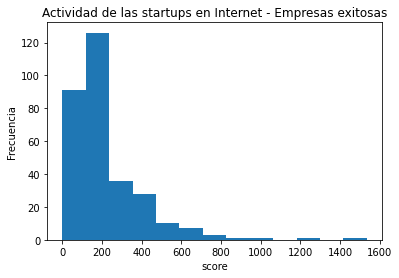

In [43]:
k = int(np.ceil(1+np.log2(3333)))
sub_success = df_cat_correct[df_cat_correct["status"]=="Success"]

plt.hist(sub_success["internet_score"], bins = k)
plt.xlabel("score")
plt.ylabel("Frecuencia")
plt.title("Actividad de las startups en Internet - Empresas exitosas")


Según la distribución de la actividad en internet de las empresas exitosas, tienen un puntaje que oscilan entre 0 y 1600 aproximadamente.

Text(0.5, 1.0, 'Actividad de las startups en Internet - Empresas con fracaso')

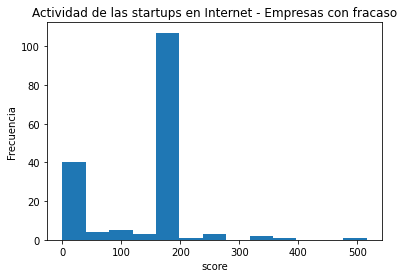

In [44]:
k = int(np.ceil(1+np.log2(3333)))

sub_failed = df_cat_correct[df_cat_correct["status"]=="Failed"]

plt.hist(sub_failed["internet_score"], bins = k)
plt.xlabel("score")
plt.ylabel("Frecuencia")
plt.title("Actividad de las startups en Internet - Empresas con fracaso")

Por otro lado, la puntuación de las empresas que tuvieron fracaso tiene una puntuación de actividad en Internet baja con respecto a las exitosas, estas oscilan entre 0 y 500. Podríamos decir que sus estrategias de marketing online no son suficientes.
Podemos inferir que las empresas que no tienen buenas estrategias de marketing online tienen altas probabilidades de fracasar.

#### big_data_business: negocio enfocado al sector del Big Data

In [45]:
pd.crosstab(index=df_cat_correct["big_data_business"], columns=df_cat_correct["status"]
           ).apply(lambda i: i/i.sum() *100,
                                axis=0)

status,Failed,Success
big_data_business,,
No,79.041916,39.016393
No Info,2.994012,0.000000
Yes,17.964072,60.983607


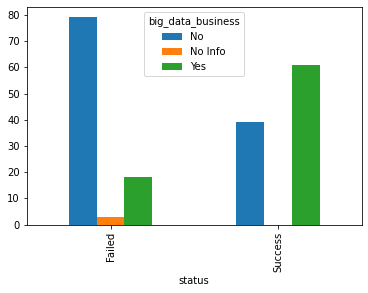

In [46]:
plot = pd.crosstab(index=df_cat_correct["status"],
            columns=df_cat_correct["big_data_business"]).apply(lambda i: i/i.sum() *100,
                                              axis=1).plot(kind='bar')


De acuerdo a la tabla de porcentaje relativos en relación al total de cada estado final de las empresas (éxito o fracaso) y al gráfico de barras que lo acompaña, podemos decir que el 79% de las empresas que fracasan no tienen como principal negocio el análisis de datos fracasan, mientras que el 61% de las empresas que tienen éxito si tienen como giro de negocio el big data. Por lo tanto, podemos inferir que si un negocio se basa en el análisis de data tienen más posibilidades de tener éxito.

**count_employee: Nº de empleados**

Text(0.5, 1.0, 'Nº empleados - Empresas exitosas')

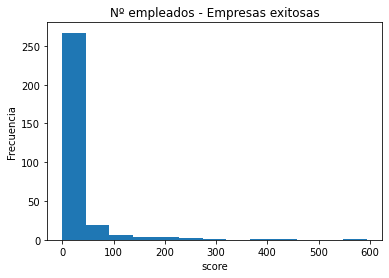

In [47]:
k = int(np.ceil(1+np.log2(3333)))
sub_success = df_cat_correct[df_cat_correct["status"]=="Success"]

plt.hist(sub_success["count_employee"], bins = k)
plt.xlabel("score")
plt.ylabel("Frecuencia")
plt.title("Nº empleados - Empresas exitosas")

Text(0.5, 1.0, 'Nº empleados - Empresas no exitosa')

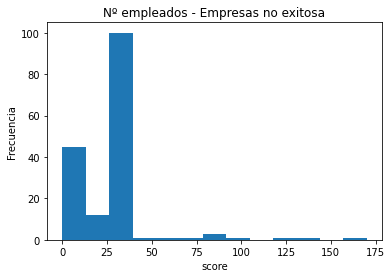

In [48]:
k = int(np.ceil(1+np.log2(3333)))

sub_failed = df_cat_correct[df_cat_correct["status"]=="Failed"]

plt.hist(sub_failed["count_employee"], bins = k)
plt.xlabel("score")
plt.ylabel("Frecuencia")
plt.title("Nº empleados - Empresas no exitosa")

## 6. Feature selection

Aquí podemos aplicar distintos métodos selección de variables y quedarnos con varios conjuntos para probar el modelo

### 6.1. Estudio de correlaciones

Sacamos un gráfico de correlaciones de las variables numéricas para tratar de eliminar variables que estén muy correlacionadas, ya que aportan información redundante.

In [81]:
df_numeric=df_cat_correct.select_dtypes(include=["float64"]) #selecciono numericas

In [82]:
corr_df = df_numeric.corr()

In [83]:
corr_df #matriz de correlaciones

,fundation_year,age_years,internet_score,count_employee,count_employee_MoM_change,last_funding_amount,number_investors_seed,number_investors_angel_VC,number_cofounders,number_advisors,team_size_senior_lead,team_size_all_employees,number_repeat_investors,years_education,renowned_professional_circle,number_recognitions_for_founders_cofounders,skills_score,google_page_rank_company_web,industry_trend_investing,number_direct_competitors,employees_per_year_existence,last_round_fundind_millionUSD,months_to_1st_investment,avg_time_to_investment,perc_skill_entrepreneur,perc_skill_operations,perc_skill_engineering,perc_skill_marketing,perc_skill_leadership,perc_skill_datascience,perc_skill_business_strategy,perc_skill_product_manag,perc_skill_sales,perc_skill_domain,perc_skill_law,perc_skill_consulting,perc_skill_finance,perc_skill_investment,renown_score
fundation_year,1.000000,-1.000000,0.117555,-0.306986,0.110080,-0.217145,0.187653,-0.086712,0.213580,-0.041383,-0.248126,-0.138592,-0.055159,0.017569,0.036535,-0.000638,-0.109757,-0.037967,-0.009140,0.017723,-0.033142,-0.253052,-0.506344,-0.278993,0.063043,0.007418,0.056116,0.026370,-0.011981,0.063371,-0.041257,-0.022389,-0.024865,-0.018421,0.069946,0.018181,0.022646,0.055070,-0.079349
age_years,-1.000000,1.000000,-0.117555,0.306986,-0.110080,0.217145,-0.187653,0.086712,-0.213580,0.041383,0.248126,0.138592,0.055159,-0.017569,-0.036535,0.000638,0.109757,0.037967,0.009140,-0.017723,0.033142,0.253052,0.506344,0.278993,-0.063043,-0.007418,-0.056116,-0.026370,0.011981,-0.063371,0.041257,0.022389,0.024865,0.018421,-0.069946,-0.018181,-0.022646,-0.055070,0.079349
internet_score,0.117555,-0.117555,1.000000,0.139861,0.025789,0.067705,0.114626,-0.063713,0.089144,0.039660,0.123083,0.204459,0.041061,-0.022166,0.091063,0.081916,0.024571,-0.242407,-0.003328,-0.028976,0.251788,0.070292,-0.005395,0.069541,0.020376,-0.084150,-0.004266,0.087828,-0.037954,0.031580,-0.050652,-0.006236,-0.079295,-0.121623,-0.040585,-0.005239,-0.052541,0.005861,-0.042120
count_employee,-0.306986,0.306986,0.139861,1.000000,-0.039788,0.335169,-0.079273,0.004563,-0.017773,0.078833,0.381368,0.357226,0.070999,-0.014001,0.067539,0.146207,0.046751,-0.111830,0.036161,-0.045737,0.291433,0.386645,0.349766,0.309917,-0.080004,0.010054,-0.082742,0.035874,0.151253,0.227931,0.064754,-0.049911,0.042255,-0.108960,-0.010717,0.052465,-0.049178,-0.049328,-0.051004
count_employee_MoM_change,0.110080,-0.110080,0.025789,-0.039788,1.000000,-0.013208,0.033918,0.015067,0.049089,0.009892,-0.035016,-0.040893,-0.014710,0.021888,0.046952,0.061170,0.046620,-0.015863,0.054739,0.012082,-0.009748,0.008596,-0.058138,-0.027947,0.055558,-0.001873,-0.002145,-0.050658,-0.068993,-0.045799,0.014123,-0.040464,-0.011533,-0.074702,-0.007525,-0.032648,-0.034992,0.062659,-0.008774
last_funding_amount,-0.217145,0.217145,0.067705,0.335169,-0.013208,1.000000,-0.144542,0.042465,0.010963,0.091240,0.301331,0.074420,0.146763,0.020864,0.050781,0.011093,0.130519,-0.100083,0.087954,-0.010857,0.059796,0.795699,0.119120,0.053233,-0.030617,-0.050344,0.023013,-0.069352,0.004921,0.057237,0.044603,-0.051767,-0.021380,-0.056933,-0.055214,-0.017925,-0.040034,-0.020742,0.043712
number_investors_seed,0.187653,-0.187653,0.114626,-0.079273,0.033918,-0.144542,1.000000,-0.105614,0.065438,0.004578,-0.036308,-0.043079,0.202651,-0.091941,0.040890,0.018998,-0.029260,-0.110116,-0.082304,-0.022447,-0.027264,-0.145198,-0.126422,-0.042504,0.021554,0.012876,0.052212,-0.066584,0.004881,-0.045891,-0.028226,0.115386,-0.026896,-0.002051,0.023472,-0.004635,0.006107,0.089469,0.064920
number_investors_angel_VC,-0.086712,0.086712,-0.063713,0.004563,0.015067,0.042465,-0.105614,1.000000,0.015771,-0.065666,0.092353,-0.029107,0.151667,0.074352,-0.062900,0.026084,-0.025589,-0.045909,0.109334,-0.068375,-0.043049,0.020233,0.055739,0.018566,0.026353,-0.076569,-0.011346,0.001092,-0.022864,0.000251,-0.043227,-0.016081,-0.061538,-0.074276,-0.025585,-0.000142,0.009279,-0.016686,-0.025519
number_cofounders,0.213580,-0.2135

In [84]:
corr_df_abs = corr_df.abs() #matriz de correlaciones en valor absoluto
upper = corr_df_abs.where(np.triu(np.ones(corr_df_abs.shape), k=1).astype(np.bool)) #me quedo con el triángulo superior de la matriz
vars_to_drop = [c for c in upper.columns if any(upper[c] > 0.75)] #miro variables con correlación >0.75

In [79]:
vars_to_drop 

['age_years', 'employees_per_year_existence', 'last_round_fundind_millionUSD']

- age_years: correlacionada con fundation_year (correlación = -1)
- employees_per_year_existence: correlacionada con team_size_all_employees (correlación = 0.94)
- last_round_fundind_millionUSD: correlacionada con last_funding_amount (correlación = 0.80)

In [85]:
df_corr_elim=df_cat_correct.drop(columns=['age_years','employees_per_year_existence','last_round_fundind_millionUSD'])

### 6.2. Selección de variables

**Variables numéricas: selección mediante AUC**

In [163]:
def get_auc(df, score_col,label_col):  #ya cambiada
    
    avg_df=df.groupby(label_col)[score_col].mean()
    avg_failed = avg_df.values[0]
    avg_success = avg_df.values[1]

    if avg_failed > avg_success:

        df[score_col] = -1.0*df[score_col]

    else:

        df

    x=df[score_col].to_numpy()
    y = df[label_col].to_numpy()

    new_y = [1 if item =='Success' else 0 for item in y]
    auc=roc_auc_score(new_y, x)

    return auc

In [164]:
def feature_selection_auc(df, threshold, cols_to_filter, label_col = 'status'):


    auc_results = [(f, get_auc(df_corr_elim, score_col=f, label_col='status')) for f in input_cols] 


    auc_results = sorted(auc_results, key=lambda tup: tup[1], reverse=True)

    for (f, r) in auc_results:
            print ("[Info] " + f + ": " + str(r))
            
    n = threshold if (threshold >= 1) else round(threshold * len(auc_results))

    num_cols = [f[0] for f in auc_results][0:n]


    return num_cols

In [165]:
input_cols= df_corr_elim.select_dtypes(include=["float64"]).columns #selecciono numericas para aplicar este método

feature_selection_auc(df_corr_elim, 0.8, input_cols, label_col = 'status') #cambiar threshold

[Info] google_page_rank_company_web: 0.7340924707961126
[Info] renowned_professional_circle: 0.7067733385687641
[Info] fundation_year: 0.7012368705212526
[Info] team_size_senior_lead: 0.6941199568076961
[Info] number_cofounders: 0.6267105133994306
[Info] industry_trend_investing: 0.6139000687150289
[Info] perc_skill_investment: 0.5956611367429075
[Info] internet_score: 0.5903504466476882
[Info] perc_skill_operations: 0.5841464611760085
[Info] number_advisors: 0.5797879650534995
[Info] perc_skill_product_manag: 0.577913026406204
[Info] perc_skill_datascience: 0.5623147148326298
[Info] perc_skill_domain: 0.5460096201040543
[Info] renown_score: 0.5447138509865516
[Info] number_recognitions_for_founders_cofounders: 0.5436242269559242
[Info] perc_skill_business_strategy: 0.538068126042996
[Info] number_investors_seed: 0.5336310984588202
[Info] last_funding_amount: 0.5220967900265044
[Info] years_education: 0.5195248846569156
[Info] perc_skill_entrepreneur: 0.5160498674781584
[Info] number_r

['google_page_rank_company_web',
 'renowned_professional_circle',
 'fundation_year',
 'team_size_senior_lead',
 'number_cofounders',
 'industry_trend_investing',
 'perc_skill_investment',
 'internet_score',
 'perc_skill_operations',
 'number_advisors',
 'perc_skill_product_manag',
 'perc_skill_datascience',
 'perc_skill_domain',
 'renown_score',
 'number_recognitions_for_founders_cofounders',
 'perc_skill_business_strategy',
 'number_investors_seed',
 'last_funding_amount',
 'years_education',
 'perc_skill_entrepreneur',
 'number_repeat_investors',
 'skills_score',
 'perc_skill_engineering',
 'perc_skill_sales',
 'count_employee',
 'perc_skill_marketing',
 'count_employee_MoM_change',
 'perc_skill_leadership',
 'avg_time_to_investment']

**Variables categóricas: selección mediante Chi-squared, information gain**

In [ ]:
'''

Code in pyspark (tengo que modificarlo):


def feature_selection_chi_squared(df, string_cols, threshold = 0.05, label_col = 'label', pcg = 1.0):
    """
    Selects categorical variables based on a Chi-Squared test.
    :param df: IDS df
    :param threshold: Threshold p-value that do not have to be exceeded
    :param string_cols: List containing the name of the categorical variables to filter
    :return: A list with the name of the numerical categorical that have passed the filter
    """

    df = df.select(string_cols + [label_col]).sample(withReplacement=False, fraction=pcg)

    df = only_categorical_columns(df, label_col=label_col)

    df.cache()

    print "[Info] Number of rows in the DF: " + str(df.count())

    string_cols = list(set(df.columns) - set([label_col]))

    print('[INFO] Indexing categorical variables: ' + str(len(string_cols)))
    new_df = df
    stages = []
    for c in string_cols:
        new_df = new_df.withColumnRenamed(c, c + '_raw')  # store old columns with suffix _raw
        indexer = StringIndexer(inputCol=(c + '_raw'), outputCol=c)
        stages += [indexer]

    pipeline = Pipeline(stages=stages)
    new_df = pipeline.fit(new_df).transform(new_df)  # new_df contains also indexed string vars

    # output: valid_vars and not_pred_vars
    # Second pipeline: assembler for chi-squared
    assembler_input = string_cols
    assembler = VectorAssembler(inputCols=assembler_input, outputCol='features')
    stages = [assembler]

    pipeline = Pipeline(stages=stages)
    output_data = pipeline.fit(new_df).transform(new_df).select('features', label_col)

    # Third pipeline: chi-squared selector
    selector = ChiSqSelector(fpr=threshold, featuresCol='features', outputCol='selectedFeatures', labelCol=label_col)

    print('[INFO] Calculating Chi-squared test categorical variables: ' + str(len(string_cols)))
    result_df = selector.fit(output_data).transform(output_data)

    result_df.show()

    print "[Info] Result DF showed above"

    # Extract variables that related to label according to the test
    list_extract = []
    for i in result_df.schema['selectedFeatures'].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + result_df.schema['selectedFeatures'].metadata["ml_attr"]["attrs"][i]

    varlist = pd.DataFrame(list_extract)

    # Drop independent categorical variables
    if varlist.empty:
        cat_cols = []
    else:
        cat_cols = list(varlist['name'])

    return cat_cols

# 2.2. Feature selection based on Information Gain

def feature_selection_information_gain(df, string_cols, threshold = 0.01, label_col = 'label', pcg = 1.0):
    """
     Selects categorical variables based on their information gain.
     :param df: IDS df
     :param threshold: percentage of reduction wrt initial entropy Ht (Ht is small in clearly unbalanced datasets)
     :param string_cols: List containing the name of the categorical variables to filter
     :return: A list with the name of the numerical categorical that have passed the filter
     """

    df = df.select(string_cols + [label_col]).sample(withReplacement=False, fraction=pcg)

    df = only_categorical_columns(df, label_col=label_col)

    df.cache()

    print "[Info] Number of rows in the DF: " + str(df.count())

    string_cols = list(set(df.columns) - set([label_col]))

    # First pipeline: string indexer variables -> necessary to use them in models
    print('[INFO] Indexing categorical variables: ' + str(len(string_cols)))

    ig_df = information_gain(df=df, var_list=string_cols, label_col = label_col)

    cat_cols = ig_df\
        .filter(col('ig') >= (threshold)*col('init_entropy'))\
        .select('feature').rdd.map(lambda r: r['feature']).collect()

    # [ig[0] for ig in ig_results if (ig[1] >= threshold_abs)]

    return cat_cols
    
'''

**Selección mediante stepwise**

## 5. Transformaciones necesarias para poder aplicar el modelo

### Assembler

Para aplicar el modelo en python antes es necesario aplicar VectorAssembler para que todas las variables input estén en un solo vector (features vector)

### Split en train y test

### Balancear variable target

Si está muy desbalanceada. Se pueden probaas distintas técnicas: downsampling, oversampling... en RandomForest sé que hay una opción que te permite especificar si está desbalanceada y ya hace directamente los ajustes (suele ser la mejor opción)

## 6. Modelo

Probar distintos algoritmos, distintos conjuntos de variables, parámetros (grid search, random search...), importancia de variables, métricas de evaluación...